# CASIA-WebFace Inpainting con imagen de referencia
En este experimento se implementará y entrenará un modelo de image inpainting sobre el dataset de MNIST, utilizando una segunda imágen como referencia. 

Se entrenará un modelo capaz de regenerar secciones faltantes dentro de imágenes de MNIST de forma realista. El modelo consiste de Deep Convolutional Networks, y se entrenará mediante un framework GAN, es decir, se entrenará un modelo generador y un discriminador en simultaneo.

En esta versión, el generador recibe tanto la imágen con la sección a ser regenerada, como otra imagen de referencia del mismo dígito.

## Imports y setup

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.transform import resize

from IPython import display

In [2]:
print(tf.__version__)

1.11.0


In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"]=""

## Carga del dataset

Usaremos el dataset de MNIST para entrenar al generador y al discriminador, el cual viene incluido dentro de la API de tf.keras. Del dataset de training se utiliza un 90% para el entrenamiento, y se separa un 10% para validación. En cada uno de estos datasets se separa un conjunto de imágenes para ser enmascaradas (las cuales seran regeneradas por el generador), y otro conjunto de imágenes para usar de referencia. A su vez, en el dataset de entrenamiento se separa un tercer conjunto de imágenes reales para entrenar al discriminador.

In [4]:
DATASET_PATH = "../../../datasets/CASIA-WebFace/CASIA-WebFace/"
DATASET_TRAIN_REFERENCE_PATH = "../../../datasets/CASIA-WebFace/CASIA-WebFace/train/reference"

IMAGE_SIZE = 128
PATCH_SIZE = 32

BATCH_SIZE = 16

PARALLEL_MAP_THREADS = 5

In [5]:
def get_reference_image(image, image_path):
  # Need to do this because when calling this function using tf.py_func, 
  # the image_path is passed as bytes instead of string.
  image_path = image_path.decode('UTF-8') 
  
  identity = image_path.split('/')[-2]
  references = train_reference_dict[identity]
  idx = np.random.randint(len(references))
  return (image, references[idx])

In [6]:
def get_reference_image_from_file(image, image_path):
  # Need to do this because when calling this function using tf.py_func, 
  # the image_path is passed as bytes instead of string.
  image_path = image_path.decode('UTF-8') 
  
  identity = image_path.split('/')[-2]
  reference_paths = train_reference_paths_dict[identity]
  idx = np.random.randint(len(reference_paths))
  image_file_name = reference_paths[idx]
  
  reference_image =  plt.imread(os.path.join(DATASET_TRAIN_REFERENCE_PATH, identity, image_file_name))
  reference_image = fix_image_encoding(reference_image)
  
  return (image, reference_image)

In [7]:
def fix_image_encoding(image):
  if (image.ndim == 2):
    # Add new dimension for channels
    image = image[:,:,np.newaxis] 
  if (image.shape[-1] == 1):
    # Convert greyscale to RGB
    image = np.concatenate((image,)*3, axis=-1)
  return image

In [8]:
def create_reference_dict(base_path):
  reference_dict = {}
  for identity_dir in os.listdir(base_path):
    images = []
    full_identity_dir = os.path.join(base_path, identity_dir)
    for image_path in os.listdir(full_identity_dir):
      image =  plt.imread(os.path.join(full_identity_dir, image_path))
      image = fix_image_encoding(image)

#     This will be done over the dataset
#     image = image / 255.0
      images.append(image)
    identity = identity_dir.split('/')[-1]
    reference_dict[identity] = images
    assert len(images) > 0
  return reference_dict

In [9]:
def create_reference_paths_dict(base_path):
  reference_dict = {}
  for identity_dir in os.listdir(base_path):
    image_paths = []
    full_identity_dir = os.path.join(base_path, identity_dir)
    for image_path in os.listdir(full_identity_dir):
      image_paths.append(image_path)
    identity = identity_dir.split('/')[-1]
    reference_dict[identity] = image_paths
    assert len(image_paths) > 0
  return reference_dict

In [10]:
# train_reference_dict = create_reference_dict(os.path.join(DATASET_PATH, "train/reference"))

In [11]:
train_reference_paths_dict = create_reference_paths_dict(os.path.join(DATASET_PATH, "train/reference"))

In [12]:
train_reference_paths_dict['0908700']

['023.jpg', '021.jpg', '020.jpg', '024.jpg', '022.jpg', '019.jpg']

In [13]:
def get_mask_fn(img_size, patch_size):

  patch_start = (img_size - patch_size) // 2
  img_size_after_patch = img_size - (patch_start + patch_size)
  
  def mask_fn(image, reference_image):
    """
    Applies a mask of zeroes of size (patch_size x patch_size) at the center of the image.
    Returns a tuple of the masked image and the original image.
    """
    upper_edge = tf.ones([patch_start, img_size, 3], tf.float32)
    lower_edge = tf.ones([img_size_after_patch, img_size,3], tf.float32)

    middle_left = tf.ones([patch_size, patch_start, 3], tf.float32)
    middle_right = tf.ones([patch_size, img_size_after_patch, 3], tf.float32)

    zeros = tf.zeros([patch_size, patch_size, 3], tf.float32)

    middle = tf.concat([middle_left, zeros, middle_right], axis=1)
    mask = tf.concat([upper_edge, middle, lower_edge], axis=0)

    return (image * mask, image, reference_image)

  return mask_fn

In [14]:
# Make a Dataset of file names including all the PNG images files in
# the relative image directory.
real_filenames_dataset = tf.data.Dataset.list_files(os.path.join(DATASET_PATH, "train/real/*/*.jpg"))
masked_filenames_dataset = tf.data.Dataset.list_files(os.path.join(DATASET_PATH, "train/masked/*/*.jpg"))

# Make a Dataset of image tensors by reading and decoding the files, 
# and the path name for each image.
real_dataset = real_filenames_dataset.map(lambda x: (tf.image.decode_image(tf.read_file(x), channels=3), x), 
      num_parallel_calls=PARALLEL_MAP_THREADS)
masked_dataset = masked_filenames_dataset.map(lambda x: (tf.image.decode_image(tf.read_file(x), channels=3), x), 
      num_parallel_calls=PARALLEL_MAP_THREADS)

In [15]:
SHUFFLE_BUFFER_SIZE = 1000

real_dataset_mapped = real_dataset.map(
    lambda image, path: tuple(
      tf.py_func(get_reference_image_from_file, [image, path], [tf.uint8, tf.uint8])), 
      num_parallel_calls=PARALLEL_MAP_THREADS).map(
      lambda image, reference: (tf.image.resize_image_with_crop_or_pad(image, IMAGE_SIZE, IMAGE_SIZE), 
                                tf.image.resize_image_with_crop_or_pad(reference, IMAGE_SIZE, IMAGE_SIZE)), 
      num_parallel_calls=PARALLEL_MAP_THREADS).map(
    lambda image, reference: (tf.image.convert_image_dtype(image, tf.float32), 
                              tf.image.convert_image_dtype(reference, tf.float32)), 
      num_parallel_calls=PARALLEL_MAP_THREADS).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

masked_dataset_mapped = masked_dataset.map(
    lambda image, path: 
      tf.py_func(get_reference_image_from_file, [image, path], [tf.uint8, tf.uint8]), 
      num_parallel_calls=PARALLEL_MAP_THREADS).map(
      lambda image, reference: (tf.image.resize_image_with_crop_or_pad(image, IMAGE_SIZE, IMAGE_SIZE), 
                                tf.image.resize_image_with_crop_or_pad(reference, IMAGE_SIZE, IMAGE_SIZE)), 
      num_parallel_calls=PARALLEL_MAP_THREADS).map(
    lambda image, reference: (tf.image.convert_image_dtype(image, tf.float32),
                              tf.image.convert_image_dtype(reference, tf.float32)), 
      num_parallel_calls=PARALLEL_MAP_THREADS).map(
    get_mask_fn(IMAGE_SIZE, PATCH_SIZE), 
      num_parallel_calls=PARALLEL_MAP_THREADS).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [16]:
train_dataset = tf.data.Dataset.zip((real_dataset_mapped, masked_dataset_mapped))

In [17]:
# iterator = train_dataset.make_one_shot_iterator()
# images = iterator.get_next()
# (full_images, full_reference_images) = images[0]
# (masked_images, unmasked_images, masked_reference_images) = images[1]

# print(full_images.shape)
# print(full_reference_images.shape)
# print(masked_images.shape)
# print(unmasked_images.shape)
# print(masked_reference_images.shape)


# plt.figure()
# plt.imshow(full_images[0])
# plt.figure()
# plt.imshow(full_reference_images[0])
# plt.figure()
# plt.imshow(masked_images[0])
# plt.figure()
# plt.imshow(unmasked_images[0])
# plt.figure()
# plt.imshow(masked_reference_images[0])


### Validation set

In [18]:
def show_and_save_images(images, name):
  fig = plt.figure(figsize=(10,10))
  
  for i in range(images.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(images[i, :, :, :])
      
      plt.axis('off')
        
  plt.savefig(name)
  plt.show()

/home/gaston/workspace/virtualenvs/tf-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/gaston/workspace/virtualenvs/tf-gpu/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Imágenes enmascaradas
(9, 128, 128, 3)


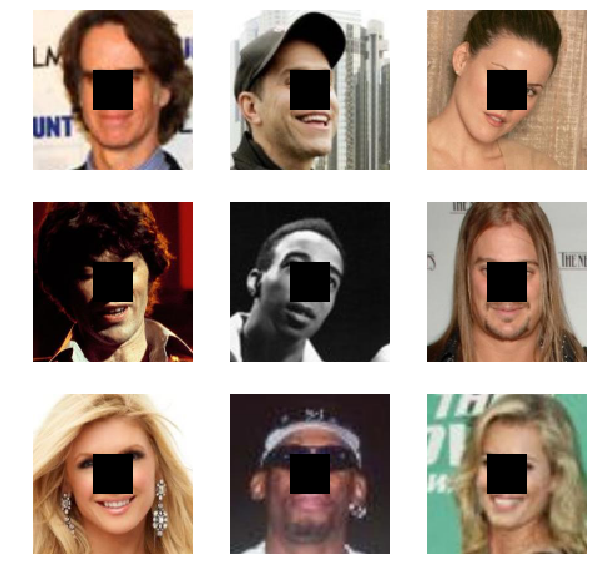

Imágenes reales
(9, 128, 128, 3)


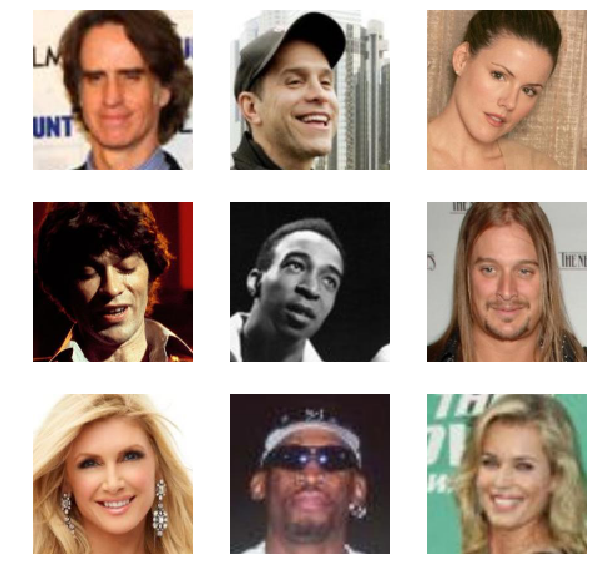

Imágenes de referencia
(9, 128, 128, 3)


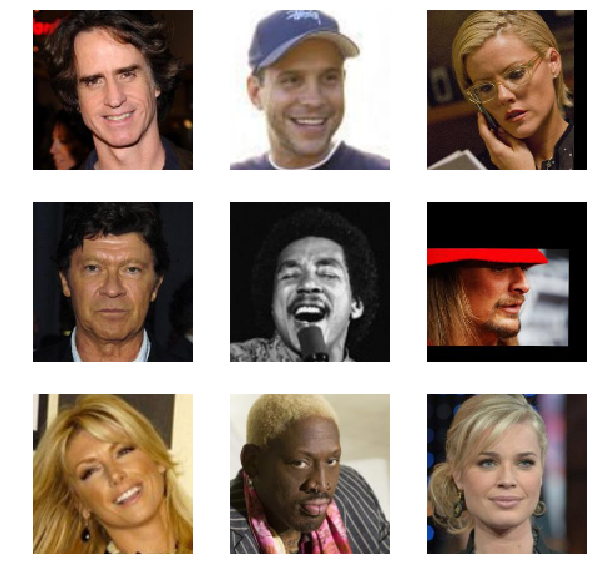

In [19]:
VALIDATION_IDENTITIES = [
  "0005366",
  "0005367",
  "0005370",
  "0005371",
  "0005373",
  "0005376",
  "0005378",
  "0005379",
  "0005381"
]

validation_images = []
validation_references = []
for identity in VALIDATION_IDENTITIES:
    full_identity_dir = os.path.join(DATASET_PATH, "validation", identity)
    mask_image =  plt.imread(os.path.join(full_identity_dir, "001.jpg"))
    reference_image = plt.imread(os.path.join(full_identity_dir, "002.jpg"))
    mask_image = fix_image_encoding(mask_image)
    reference_image = fix_image_encoding(reference_image)
    
    mask_image = resize(mask_image, (IMAGE_SIZE,IMAGE_SIZE))
    reference_image = resize(reference_image, (IMAGE_SIZE,IMAGE_SIZE))
    
    validation_images.append(mask_image)
    validation_references.append(reference_image)

validation_masked_images = []
mask_fn = get_mask_fn(IMAGE_SIZE, PATCH_SIZE)
for mask_image, reference_image in zip(validation_images, validation_references):
  mask_image, _, _ = mask_fn(mask_image, reference_image)
  validation_masked_images.append(mask_image.numpy())

validation_images = np.array(validation_images).astype('float32')
validation_references = np.array(validation_references).astype('float32')
validation_masked_images = np.array(validation_masked_images).astype('float32')

print("Imágenes enmascaradas")
print(validation_masked_images.shape)
show_and_save_images(validation_masked_images, 'validation_imgs/validation_masked_images.png')
print("Imágenes reales")
print(validation_images.shape)
show_and_save_images(validation_images, 'validation_imgs/validation_unmasked_images.png')
print("Imágenes de referencia")
print(validation_references.shape)
show_and_save_images(validation_references, 'validation_imgs/validation_reference_images.png')

## Creación de los modelos

### Encoder (VGG)

In [20]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, 
                                            weights='imagenet', 
                                            input_tensor=None,
                                            input_shape=(128, 128, 3))
# Remove last 5 conv layers.
# ENCODER.outputs = [ENCODER.layers[-6].output]

vgg16.trainable = False


encoder = tf.keras.Model(inputs = vgg16.inputs, outputs=vgg16.layers[-6].output)
encoder.trainable = False

### Generador

El generador recibe como entrada dos imágenes: una imágen enmascarada de un dígito, y otra imágen de referencia de ese mismo dígito. Su objetivo es regenerar las secciones faltantes en las imágenes enmascaradas de forma realista, tomando como referencia la segunda imagen. 

La arquitectura del generador consiste de dos Encoders y un Decoder. Un Encoder recibe la imágen enmascarada, y el otro Encoder recibe la imágen de referencia. Cada enconder consiste de 3 capas convolucionales, con Batch Normalization y Leaky ReLU.

Luego, los resultados de ambos encoders son concatenados y enviados al Decoder. El Decoder aplica 3 capas convolucionales transpuestas hasta generar una imágen del tamaño de la región faltante. Esta imágen será el output del generator.

In [21]:
def make_generator_model():
  
  masked_image = tf.keras.Input(shape=(128, 128, 3,), name='masked_image')
  masked_encoding = encoder(masked_image)
  # 16x16x512
  
  reference_image = tf.keras.Input(shape=(128, 128, 3,), name='reference_image')
  reference_encoding = encoder(reference_image)
  # 16x16x512

  encoding = tf.keras.layers.concatenate([masked_encoding, reference_encoding], axis=-1)
  # 16x16x1024
  
  # Decoder
  encoding = tf.keras.layers.Conv2DTranspose(256, (2, 2), 
                                                    strides=(1, 1), 
                                                    padding='same', 
                                                    use_bias=False, 
                                                    input_shape=(16,16,1024))(encoding)
  encoding = tf.keras.layers.BatchNormalization()(encoding)
  encoding = tf.keras.layers.LeakyReLU()(encoding)
  # 16x16x256

  encoding = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', use_bias=False)(encoding)
  encoding = tf.keras.layers.BatchNormalization()(encoding)
  encoding = tf.keras.layers.LeakyReLU()(encoding)
  # 32x32x32

  generated_patch = tf.keras.layers.Conv2DTranspose(3, (5, 5), 
                                                    strides=(1, 1), 
                                                    padding='same', 
                                                    use_bias=False, 
                                                    activation='sigmoid')(encoding)
  # 32x32x3
  
  return tf.keras.Model(inputs=[masked_image, reference_image], outputs=generated_patch)
  

### Discriminador

El discriminador recibe como entrada dos imágenes: una imágen que puede ser real o tener una sección regenerada por el generador, y otra imágen de referencia de ese mismo dígito. Su objetivo ees distinguir entre imágenes reales e imágenes regeneradas por el generador, basandose tanto en la primer imagen como en la imagen de referencia.

La arquitectura del discriminador consiste de dos Encoders y un clasificador. Uno de los encoders recibe la primer imágen (la cual puede ser real o generada), y el otro Encoder recibe la imágen de referencia. Cada enconder consiste de 2 capas convolucionales, con función de activación Leaky ReLU y Dropout.

Luego, los resultados de ambos encoders son concatenados y enviados al clasificador. El clasificador aplica 2 capas fully-connected para determinar si la primer imágen es real o falsa.

In [22]:
def make_discriminator_model():
  
  image = tf.keras.Input(shape=(128, 128, 3,), name='image')
  image_encoding = vgg16(image)
  # 4x4x512
  
  image_encoding = tf.keras.layers.Conv2D(64, (1, 1),
                                                strides=(1, 1), 
                                                padding='same', 
                                                input_shape=(4, 4, 512))(image_encoding)
  image_encoding = tf.keras.layers.BatchNormalization()(image_encoding)
  image_encoding = tf.keras.layers.LeakyReLU()(image_encoding)
  # 4x4x64
  
  image_encoding = tf.keras.layers.Flatten()(image_encoding)
  # 1024
  
  reference_image = tf.keras.Input(shape=(128, 128, 3,), name='reference_image')
  reference_encoding = vgg16(reference_image)
  # 4x4x512
  
  reference_encoding = tf.keras.layers.Conv2D(64, (1, 1),
                                                strides=(1, 1), 
                                                padding='same', 
                                                input_shape=(4, 4, 512))(reference_encoding)
  reference_encoding = tf.keras.layers.BatchNormalization()(reference_encoding)
  reference_encoding = tf.keras.layers.LeakyReLU()(reference_encoding)
  # 4x4x64
  
  reference_encoding = tf.keras.layers.Flatten()(reference_encoding)
  # 1024
  
  encoding = tf.keras.layers.concatenate([image_encoding, reference_encoding], axis=-1)
  # 2048
  
  # Classifier
  encoding = tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu)(encoding)
  logits = tf.keras.layers.Dense(1)(encoding)
  
  return tf.keras.Model(inputs=[image, reference_image], outputs=logits)

In [23]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [24]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
masked_image (InputLayer)       (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
reference_image (InputLayer)    (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 16, 16, 512)  7635264     masked_image[0][0]               
                                                                 reference_image[0][0]            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 16, 16, 1024) 0           model[1][0]                      
          

In [25]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
reference_image (InputLayer)    (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 4, 4, 512)    14714688    image[0][0]                      
                                                                 reference_image[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4, 4, 64)     32832       vgg16[1][0]                      
__________

## Funciones de costo y optimizadores

A continuación se definen las funciones de costo para ambos modelos, y los optimizadores a utilizar para minimizar dichas funciones.

### Función de costo del generador
La función de costo del generador consiste de una función de Sigmoid Cross Entropy sobre las imágenes generadas. Se busca que la salida del discriminador sea 1 (reales) para dichas imágenes.

In [26]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

### Función de costo del discriminador

La función de costo del discriminador tiene dos partes:
1. Costo sobre imágenes reales: consiste de una Sigmoid Cross Entropy sobre las imágenes reales. Se busca que la salida del discriminador sea 1 (reales) para dichas imágenes.
2. Costo sobre imágenes generadas: consiste de una Sigmoid Cross Entropy sobre las imágenes generadas por el generador. Se busca que la salida del discriminador sea 0 (falsas) para dichas imágenes.

Luego se suman estas dos funciones para obtener la función de costo del discriminador.

In [27]:
def discriminator_loss(real_output, generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

### Optimizadores
Se utiliza un optimizador Adam para cada modelo, ya que estos se entrenan en paralelo.

In [28]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

## Checkpoints
Los parámetros de ambos modelos se almacenarán como checkpoints durante el entrenamiento, para poder recuperarlos luego.

In [29]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Configuración del entrenamiento

### Paso de entrenamiento

En cada paso del entrenamiento, el generador recibe un batch de imágenes enmascaradas junto con sus respectivas imágenes de referencias, y regenera las secciones faltantes. Estas regiones generadas son luego insertadas en las imágenes del batch, completando las secciones faltantes con las regiones generadas por el generador. Luego, el discriminador recibe por un lado estas imágenes con las secciones regeneradas junto con sus imágenes de referencia, y por otro lado un batch de imágenes reales, también con sus imágenes de referencia. 

A continuación, en base a los resultados del discriminador se calculan las funciones de costo de ambos modelos. Y finalmente, se aplica un paso de los optimizadores para cada modelo.

In [30]:
def patch_image(patch, image):
  """
  Apply the given patch to the image.
  The patch is applied at the center of the image, assuming a 7x7 patch and a 28x28 image.
  """
  
  patch_start = (IMAGE_SIZE - PATCH_SIZE) // 2
  patch_end = patch_start + PATCH_SIZE
  
  # TODO: See if this could be done more efficiently.
  
  upper_edge = image[:, :patch_start, :, :]
  lower_edge = image[:, patch_end:, :, :]
  
  middle_left = image[:, patch_start:patch_end, :patch_start, :]
  middle_right = image[:, patch_start:patch_end, patch_end:, :]
  
  middle = tf.concat([middle_left, patch, middle_right], axis=2)
  return tf.concat([upper_edge, middle, lower_edge], axis=1)


In [31]:
def train_step(full_images, full_reference_images, masked_images, masked_reference_images):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_patches = generator([masked_images, masked_reference_images], training=True)
    generated_images = patch_image(generated_patches, masked_images)
    
    real_output = discriminator([full_images, full_reference_images], training=True)
    generated_output = discriminator([generated_images, masked_reference_images], training=True)
    
    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
  
  return gen_loss, disc_loss

Debido a que ejecutar el entrenamiento de forma secuencial suele ser más lento que ejecutar el grafo de operaciones equivalente, utilizamos la función [tf.contrib.eager.defun](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/defun) para generar el grafo de operaciones y así obtener una mejora en la performance.

In [32]:
train_step_graph = tf.contrib.eager.defun(train_step)

### Proceso completo de entrenamiento
Aquí definimos el proceso completo de entrenamiento. Se itera sobre todo el dataset por cada epoch, y por cada batch del dataset se aplica un paso de entrenamiento. Luego de cada epoch, se muestran las imágenes de validación con las secciones regeneradas por el discriminador, y se grafican las funciones de costo de ambos modelos.

In [33]:
EPOCHS = 50
BATCHES_PER_PRINT = 10
BATCHES_PER_CHECKPOINT = 50


In [38]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  
  global_step = tf.train.get_or_create_global_step()

  logdir = "./checkpoints"
  writer = tf.contrib.summary.create_file_writer(logdir)
  writer.set_as_default()

  
  for epoch in range(epochs):
    epoch_start = time.time()
    
    for images in dataset:
      batch_start = time.time()
      global_step.assign_add(1)
      
      with tf.contrib.summary.record_summaries_every_n_global_steps(BATCHES_PER_PRINT):
        (full_images, full_reference_images) = images[0]
        (masked_images, unmasked_images, masked_reference_images) = images[1]
        gen_loss, disc_loss = train_step_graph(full_images, full_reference_images, masked_images, masked_reference_images)
        
        batch_end = time.time()
        batch_time = batch_end-batch_start
        global_steps_per_second = 1 / batch_time if batch_time > 0 else 0
        tf.contrib.summary.scalar('global_step', global_steps_per_second)
        tf.contrib.summary.scalar('gen_loss', gen_loss)
        tf.contrib.summary.scalar('disc_loss', disc_loss)
        
        generated_images = generate_images(generator,
                         validation_masked_images,
                         validation_references)
        
        tf.contrib.summary.image('generated_images', generated_images)
                
     
      if (global_step.numpy() % BATCHES_PER_PRINT == 0):
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        display.clear_output(wait=True)
        generated_images = generate_images(generator,
                         validation_masked_images,
                         validation_references)
        show_and_save_images(generated_images, 'validation_imgs/image_at_epoch_{:04d}_batch_{:08d}.png'.format(epoch + 1, global_step.numpy() + 1))
        plot_losses(gen_losses, disc_losses)
        print('Current epoch: {}'.format(epoch + 1))
        print ('Time taken for batch {} is {} sec'.format(global_step.numpy(), batch_time))
        
      if (global_step.numpy() % BATCHES_PER_CHECKPOINT == 0):
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-epoch_start))
  # generating after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           0,
                           validation_masked_images,
                           validation_references)
  plot_losses(gen_losses, disc_losses)

In [39]:
def plot_losses(gen_loss, disc_loss): 
  batch_axis = range(BATCHES_PER_PRINT, (len(gen_loss) + 1)*BATCHES_PER_PRINT, BATCHES_PER_PRINT)
  plt.plot(batch_axis, gen_loss)
  plt.plot(batch_axis, disc_loss)
  plt.xlabel('Batch')
  plt.ylabel('Loss')
  plt.title('Generator and Discriminator Losses')
  plt.legend(['Gen loss', 'Disc loss'])
  plt.show()

In [40]:
def generate_images(generator, masked_images, reference_images):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  patches = generator([masked_images, reference_images], training=False)
  generated_images = patch_image(patches, masked_images)
  
  return generated_images

## Entrenamiento de la GAN

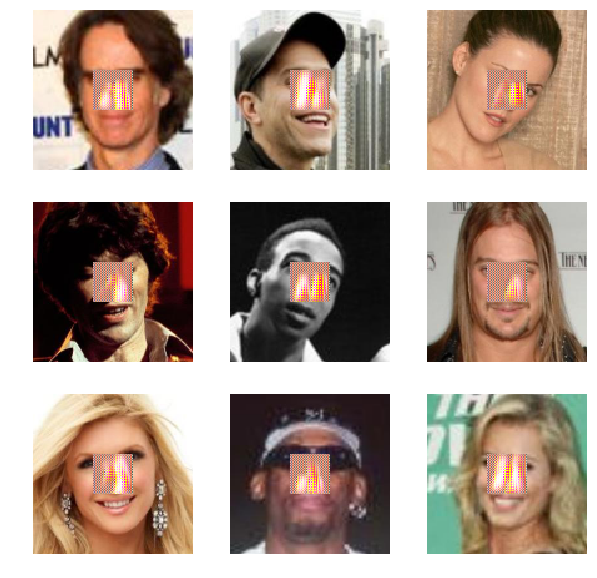

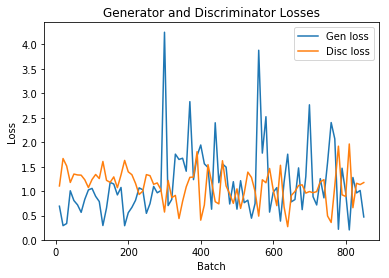

Current epoch: 1
Time taken for batch 850 is 7.900527000427246 sec


In [ ]:
%%time
train(train_dataset, EPOCHS)

**Restauración del último checkpoint**

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Resultados

Luego del entrenamiento, visualizamos los resultados obtenidos.

In [ ]:
# Display a single image using the epoch number
def display_image(name):
  return PIL.Image.open(name)

### Imágenes enmascaradas

In [ ]:
display_image('validation_masked_images.png')

### Imágenes de referencia

In [ ]:
display_image('validation_reference_images.png')

### Imágenes generadas

In [ ]:
display_image('image_at_epoch_{:04d}.png'.format(EPOCHS))

### Imágenes reales

In [ ]:
display_image('validation_unmasked_images.png')